<!--NOTEBOOK_HEADER-->
*This notebook contains material from [CBE60499](https://ndcbe.github.io/CBE60499);
content is available [on Github](git@github.com:ndcbe/CBE60499.git).*


<!--NAVIGATION-->
< [2.7 Stochastic Programming](https://ndcbe.github.io/CBE60499/02.07-SP.html) | [Contents](toc.html) | [Tag Index](tag_index.html) | [2.9 Supplementary material: data for parmest tutorial](https://ndcbe.github.io/CBE60499/02.09-Parmest-generate-data.html) ><p><a href="https://colab.research.google.com/github/ndcbe/CBE60499/blob/master/docs/02.08-Parmest-tutorial.ipynb"> <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://ndcbe.github.io/CBE60499/02.08-Parmest-tutorial.ipynb"> <img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>

In [ ]:
# IMPORT DATA FILES USED BY THIS NOTEBOOK
import os,  requests

file_links = [("data/parmest_20210609_data_exp1.csv", "https://ndcbe.github.io/CBE60499/data/parmest_20210609_data_exp1.csv"),
    ("data/parmest_log_file.csv", "https://ndcbe.github.io/CBE60499/data/parmest_log_file.csv")]

# This cell has been added by nbpages. Run this cell to download data files required for this notebook.

for filepath, fileurl in file_links:
    stem, filename = os.path.split(filepath)
    if stem:
        if not os.path.exists(stem):
            os.mkdir(stem)
    if not os.path.isfile(filepath):
        with open(filepath, 'wb') as f:
            response = requests.get(fileurl)
            f.write(response.content)


# 2.8 Parameter estimation with `parmest`

Created by [Kanishka Ghosh](https://github.com/kanishka-ghosh), [Jialu Wang](https://github.com/jialuw96), and [Prof. Alex Dowling](https://github.com/adowling2/) at the University of Notre Dame.

In [1]:
# This code cell installs packages on Colab

import sys
if "google.colab" in sys.modules:
    !wget "https://raw.githubusercontent.com/ndcbe/CBE60499/main/notebooks/helper.py"
    import helper
    helper.install_idaes()
    helper.install_ipopt()
    helper.download_data(['parmest_20210609_data_exp{:d}.csv'.format(i) for i in range(1,17)])
    helper.download_data(['parmest_log_file.csv'])
    !pyomo build-extensions

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pyomo.environ import *
from pyomo.dae import *

# Define the directory to save/read the data files
data_dir = './data/'

## 2.8.1 What is parameter estimation?

Given a function $f(x,\theta)$ where $x$ is the input or array of inputs, $\theta$ is the vector of unknown model parameters, and $y$ is the array of observed output, parameter estimation is performed to determine the values of $\theta$ to minimize the error between $f(x,\theta)$ and $y$.  Commonly, parameter estimation is set up as a least squares objective problem:

$$
\begin{align}
\begin{split}
    \min_{\hat{\theta}} \quad & \sum_{i}^{} (y_i - f(x_i,\hat{\theta}))^2\\
    \textrm{s.t.} \quad & \mathrm{bounds \ on} \ \theta\\
    & \mathrm{other \ physical \ constraints}\\
\end{split}
\end{align}
$$

where $i$ is used to index the datapoints in a dataset and $\hat{\theta}$ is the optimal set of parameter values that minimizes the prediction error.

## 2.8.2 What is `parmest`?

`parmest` is a Python package built on the [Pyomo optimization modeling language](http://www.pyomo.org/) to support parameter estimation using experimental data along with confidence regions and subsequent creation of scenarios for [PySP](https://github.com/Pyomo/pysp). `parmest` supports scenario generation for multiple 'experiments' and can be used to characterize estimate uncertainties through, for example, confidence region generations. `parmest` requires the following positional arguments in order solve the optimization problem:
1. Function that accepts an 'experimental' dataset or a list of 'experimental' datasets, each defined as a dictionary, as it's argument and returns the Pyomo model.
    
    Later in this tutorial, that function is defined above as `create_model()`


2. List of datasets where each dataset is a dictionary

    Later in this tutorial, the list of datasets is generated using the function `create_data_dict()` (defined below) and is stored in `data_dict_overall`


3. List of parameter names (as they appear in the Pyomo model definition) that are being estimated

    later in this tutorial, the list of parameter names to be estimated is defined below by `theta_names`


4. Optional keyword argument to define the verbosity of solver output.  Default: False

More information about the `parmest` package can be found [here](https://pyomo.readthedocs.io/en/stable/contributed_packages/parmest/index.html).

Detailed explanation of the various methods in `parmest` can be found [here](https://www.osti.gov/servlets/purl/1761797).


## 2.8.3 Example: Reaction Kinetics

Consider two chemical reactions that convert molecule $A$ to desired product $B$ and a less valuable side-product $C$.

$$A \overset{k_1}{\rightarrow} B \overset{k_2}{\rightarrow} C$$

Our ultimate goals is to design a large-scale continous reactor that maximizes the production of $B$. This general sequential reactions problem is widely applicable to CO$_2$ capture and industry more broadly (petrochemicals, pharmasuticals, etc.).

The rate laws for these two chemical reactions are:

$$r_A = -k_1 C_A$$

$$r_B = k_1 C_A - k_2 C_B$$

$$r_C = k_2 C_B$$

Here, $C_A$, $C_B$, and $C_C$ are the concentrations of each species. The rate constants $k_1$ and $k_2$ depend on temperature as follows:

$$k_1 = A_1 \exp{\frac{-E_1}{R T}}$$

$$k_2 = A_2 \exp{\frac{-E_2}{R T}}$$

$A_1, A_2, E_1$, and $E_2$ are fitted model parameters. $R$ is the ideal-gas constant and $T$ is absolute temperature.

### 2.8.3.1 Batch Reactor

The concentrations in a batch reactor evolve with time per the following differential equations:

$$ \frac{d C_A}{dt} = r_A = -k_1 C_A $$

$$ \frac{d C_B}{dt} = r_B = k_1 C_A - k_2 C_B $$

$$ \frac{d C_C}{dt} = r_C = k_2 C_B $$

This is a linear system of differential equations. Assuming the feed is only species $A$, i.e., 

$$C_A(t=0) = C_{A0} \quad C_B(t=0) = 0 \quad C_C(t=0) = 0$$

leads to the following analytic solution:

$$C_A(t) = C_{A,0} \exp(-k_1 t)$$

$$C_B(t) = \frac{k_1}{k_2 - k_1} C_{A,0} \left[\exp(-k_1 t) - \exp(-k_2 t) \right]$$

$$C_C(t) = C_{A,0} - \frac{k_2}{k_2 - k_1} C_{A,0} \exp(-k_1 t) + \frac{k_1}{k_2 - k_1} \exp(-k_2 t) C_{A,0} = C_{A,0} - C_{A}(t) - C_{B}(t)$$

The following Python code simulates and plots this model.

In [3]:
def kinetics(A, E, T):
    ''' Computes kinetics from Arrhenius equation
    
    Arguments:
        A: pre-exponential factor, [1 / hr]
        E: activation energy, [kJ / mol]
        T: temperature, [K]
        
    Returns:
        k: reaction rate coefficient, [1 / hr]
    
    '''
    R = 8.31446261815324 # J / K / mole
    
    return A * np.exp(-E*1000/(R*T))

def concentrations(t,k,CA0):
    '''
    Returns concentrations at time t
    
    Arguments:
        t: time, [hr]
        k: reaction rate coefficient, [1 / hr]
        CA0: initial concentration of A, [mol / L]
    
    Returns:
        CA, CB, CC: concentrations of A, B, and C at time t, [mol / L]
    '''
    CA = CA0 * np.exp(-k[0]*t);
    CB = k[0]*CA0/(k[1]-k[0]) * (np.exp(-k[0]*t) - np.exp(-k[1]*t));
    CC = CA0 - CA - CB;
    
    return CA, CB, CC

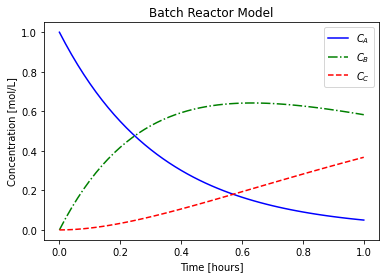

In [4]:
CA0 = 1 # Moles/L
k = [3, 0.7] # 1/hr

t = np.linspace(0,1,51)
CA, CB, CC = concentrations(t,k,CA0)
plt.plot(t, CA, label="$C_{A}$",linestyle="-",color="blue")
plt.plot(t, CB, label="$C_{B}$",linestyle="-.",color="green")
plt.plot(t, CC, label="$C_{C}$",linestyle="--",color="red")
plt.xlabel("Time [hours]")
plt.ylabel("Concentration [mol/L]")
plt.title("Batch Reactor Model")
plt.legend()
plt.show()
plt.close()

### 2.8.3.2 Experimental Data

See the notebook *Supplementary material: data for parmest tutorial* for details on how these experimental data were generated (via simulation).

Experimental data consists of the concentration of species A, B, and C in $\mathrm{mol/L}$ with respect to time $t$ in $\mathrm{hours}$ inside the batch reactor. The experimental data is stored in csv files where the first column records the time $t$ in the reactor. Next, the temperature $T$ in $\mathrm{K}$ at which the reaction was simulated is recorded followed by the initial concentration of species A, $C_{A,0}$, in $\mathrm{mol/L}$. Finally, the time-varying species concentrations ($C_A$), ($C_B$), and ($C_C$) are recorded in $\mathrm{mol/L}$. Following is how the pandas dataframe of a single experiment looks like:

In [5]:
# define function to plot
def plot_exp(k, CA0, data, text):
    ''' 
    Plot concentration profiles
    Arguments:
        k: kinetic parameters
        CA0: initial concentration
        data: Pandas data frame
        text: plot title
    
    '''
    # evaluate models
    t = np.linspace(0,1,51)
    CA, CB, CC = concentrations(t,k,CA0)
    
    # plot model-generated and 'experimental' data
    # symbols for 'experimental' data
    # solid and dashed lines for model-generated data
    plt.plot(t, CA,label="$C_{A}$",linestyle="-",color="blue")
    plt.plot(data.time, data.CA, marker='o',linestyle="",color="blue",label=str())
    plt.plot(t, CB, label="$C_{B}$",linestyle="-.",color="green")
    plt.plot(data.time, data.CB, marker='s',linestyle="",color="green",label=str())
    plt.plot(t, CC, label="$C_{C}$",linestyle="--",color="red")
    plt.plot(data.time, data.CC, marker='^',linestyle="",color="red",label=str())
    plt.xlabel("Time [hours]")
    plt.ylabel("Concentration [mol/L]")
    plt.title(text)
    plt.legend()
    plt.show()
    plt.close()

### 2.8.3.3 Pyomo model

In the following cell, we define a function to define and return the Pyomo model for the kinetic model to be used for parameter estimation.

In [6]:
def create_model(data):
    '''
    function to create Pyomo model
    Argument:
        data: a single dictionary of data
    Return:
        m: Pyomo model
    '''
    # data
    exp_data = data['data']
    
    # This code style matches parmest example found here:
    # https://github.com/Pyomo/pyomo/blob/master/pyomo/contrib/parmest/examples/semibatch/semibatch.py
    
    # unpack 'experimental' data into temporary variables
    cameastemp = exp_data['CA']
    cbmeastemp = exp_data['CB']
    ccmeastemp = exp_data['CC']
    tmeastemp = exp_data['time']
    
    # create dictionaries for 'experimental' data of CA, CB,and CC indexed by timestep
    cameas={}
    cbmeas={}
    ccmeas={}
    for i,j in enumerate(tmeastemp):
        cameas[float(j)] = cameastemp[i]
        cbmeas[float(j)] = cbmeastemp[i]
        ccmeas[float(j)] = ccmeastemp[i]
    
    # define Pyomo model
    m = ConcreteModel()
    m.T = data['T'] # K
    m.CA0 = data['CA0'] # mol/L
    
    # define 'experimental' data timesteps as Pyomo set
    m.t = Set(initialize=tmeastemp.tolist())
    
    # define 'experimental' data as Pyomo parameters indexed by timestep set and 
    # initialized by dictionary of experimental data
    m.Ca_meas = Param(m.t, initialize=cameas)
    m.Cb_meas = Param(m.t, initialize=cbmeas)
    m.Cc_meas = Param(m.t, initialize=ccmeas)
    
    m.R = 8.31446261815324 # J / K / mole
    
    # Kinetic parameters to be fitted defined as Pyomo variables
    # Initialized by 'true' values
    m.A1 = Var(initialize=200, bounds=(100,300)) # 1/hr
    m.A2 = Var(initialize=400, bounds=(300,500)) # 1/hr
    m.E1 = Var(initialize=10, bounds=(1,20)) # kJ/mol
    m.E2 = Var(initialize=15, bounds=(1,30)) # kJ/mol
    
    # Concentration variables indexed by time
    m.CA = Var(m.t, initialize = m.CA0) # mol/L
    m.CB = Var(m.t, initialize = 0) # mol/L
    m.CC = Var(m.t, initialize = 0) # mol/L
    
    
    # kinetic rate constants from Arrhenius equation
    m.k1 = Expression(rule = m.A1 * exp(-m.E1*1000/(m.R*m.T))) # 1/hr
    m.k2 = Expression(rule = m.A2 * exp(-m.E2*1000/(m.R*m.T))) # 1/hr
    
    # Constraints to change concentrations based on kinetics
    def conc_A(m,i):
        if i == 0:
            return Constraint.Skip
        else:
            return m.CA[i] == m.CA0 * exp(-m.k1*i)
    m.CA_rate = Constraint(m.t,rule=conc_A)
    
    def conc_B(m,i):
        if i == 0:
            return Constraint.Skip
        else:
            return m.CB[i] == m.k1*m.CA0/(m.k2-m.k1) * (exp(-m.k1*i) - exp(-m.k2*i))
    m.CB_rate = Constraint(m.t,rule=conc_B)
    
    def conc_C(m,i):
        if i == 0:
            return Constraint.Skip
        else:
            return m.CC[i] == m.CA0 - m.CA[i] - m.CB[i]
    m.CC_rate = Constraint(m.t,rule=conc_C)
    
    # Initial Conditions
    def _initcon(m):
        yield m.CA[m.t.first()] == m.CA0
        yield m.CB[m.t.first()] == 0.0
        yield m.CC[m.t.first()] == 0.0
    m.initcon = ConstraintList(rule=_initcon)
    
    # Objective function
    # The objective function for parmest is defined as a 2-stage stochastic optimization objective function
    
    # First stage cost: independent of scenarios ('experiments')
    #                   expression for minimizing fixed realization 
    #                   from model. Eg.: reactor temperature, size, etc.
    def ComputeFirstStageCost_rule(m):
        # In this case, we do not optimize anything besides the kinetic parameters through 
        # least square fitting realizations at each timestep defined by m.t.
        # Hence, the first stage cost is set to 0 here.
        return 0
    m.FirstStageCost = Expression(rule=ComputeFirstStageCost_rule)
    
    # Second stage cost: Realization at each scenario over which the model is defined
    def ComputeSecondStageCost_rule(m):
        # In this problem, we want to minimize the sum of squared errors between 
        # 'experimental' data and the model realization of concentrations of 
        # A, B, and C over each scenario (here, timesteps defined by m.t)
        return sum((m.CA[t] - m.Ca_meas[t]) ** 2 + (m.CB[t] - m.Cb_meas[t]) ** 2 
                       + (m.CC[t] - m.Cc_meas[t]) ** 2 for t in m.t)
    m.SecondStageCost = Expression(rule=ComputeSecondStageCost_rule)
    
    # return the sum of the first-stage and second-stage costs as the objective function
    def total_cost_rule(m):
        return m.FirstStageCost + m.SecondStageCost

    m.Total_Cost_Objective = Objective(rule=total_cost_rule, sense=minimize)
    
    return m

## 2.8.4 Parameter estimation with a single dataset

Here, we will estimate parameters $A_1$, $A_2$, $E_1$, and $E_2$ using data generated for a batch 'experiment' at 250 C with an inlet concentration of 0.5 mol/L of A.

The parameter estimation problem is solved with the least squares optimization scheme

The parameter estimation problem is solved with the least squares optimization scheme
$$
\begin{align}
\begin{split}
    \min_{\hat{\theta}} \quad & \sum_{i}^{} (y_i - f(x_i,\hat{\theta}))^2\\
    \textrm{s.t.} \quad & \mathrm{bounds \ on} \ \theta\\
    & \mathrm{other \ physical \ constraints}\\
\end{split}
\end{align}
$$
where $i$ is used to index the datapoints in a dataset and $\hat{\theta}$ is the optimal set of parameter values that minimizes the prediction error.


In [7]:
# read-in data from csv file

data = pd.read_csv('./data/parmest_20210609_data_exp1.csv',index_col=0)
# create dictionary of data
# format of dictionary needs to be consistent with input provided to create_model() function
data_dict = {}
data_dict['T'] = data['T'].iloc[0]
data_dict['CA0'] = data['CA0'].iloc[0]
data = data.drop(labels=['T','CA0'],axis=1)
data_dict['data'] = data

# create pyomo model instance
model = create_model(data_dict)

# create solver instance for IPOPT
solver = SolverFactory('ipopt')

# solve model
solver.solve(model,tee=True)

print("===  Parameter values  ===")
print("A1 = {:0.3f} 1/hr".format(value(model.A1)))
print("A2 = {:0.3f} 1/hr".format(value(model.A2)))
print("E1 = {:0.3f} kJ/mol".format(value(model.E1)))
print("E2 = {:0.3f} kJ/mol".format(value(model.E2)))

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

## 2.8.5 Parameter estimation with multiple datasets

Here, we will estimate parameters $A_1$, $A_2$, $E_1$, and $E_2$ using data generated for a batch 'experiment' at 250 C with an inlet concentration of 0.5 mol/L of A.

The parameter estimation problem is now defined to solve optimization problem where the objective function is the mean of the least square error between observed and calculated data for multiple experiments.

$$
\begin{align}
\begin{split}
    \min_{\hat{\theta}} \quad & \frac{1}{N}\sum_{j}^{}\sum_{i}^{} (y_{j,i} - f(x_{j,i},\hat{\theta}))^2\\
    \textrm{s.t.} \quad & \mathrm{bounds \ on} \ \theta\\
    & \mathrm{other \ physical \ constraints}\\
\end{split}
\end{align}
$$

where $i$ is used to index the datapoints in a dataset, $j$ is an index on the dataset such that $j \in [1,N]$ and $N$ is the number of experiments conducted.

### 2.8.5.1 Generate list of dataset

In the following cell, we define a function to generate a list of dictionaries containing the 'experimental' data.  For this, we read-in the list of file names generated earlier

{'T': 250, 'CA0': 0.5, 'data':     time        CA        CB        CC
0  0.000  0.476266  0.000000  0.000000
1  0.125  0.332309  0.133593  0.000000
2  0.250  0.295725  0.362016  0.092655
3  0.375  0.394806  0.131512  0.004404
4  0.500  0.167992  0.271682  0.031808
5  0.625  0.117872  0.313196  0.009108
6  0.750  0.117052  0.582722  0.000000
7  0.875  0.175373  0.224904  0.043844
8  1.000  0.130619  0.360287  0.194820}


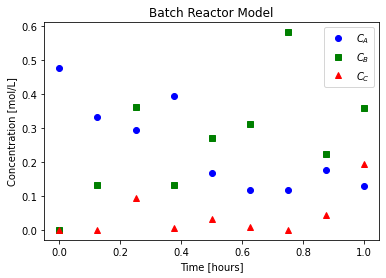

In [8]:
def create_data_dict(files):
    '''
    Create a list of dictionaries from multiple datasets
    Arguments:
        files: pandas dataframe of file names
    Return:
        data_dict_list: list of dictionaries
    '''
    data_dict_list = []
    for index, file in files.iterrows():
        # create a dictionary of 'experimental' data for temperature T and initial concentration of A CA0
        data_dict = {}
        data = pd.read_csv(str(file.values[0]),index_col=0)
        data_dict['T'] = data['T'].iloc[0]
        data_dict['CA0'] = data['CA0'].iloc[0]
        data = data.drop(labels=['T','CA0'],axis=1)
        data_dict['data'] = data
        # add dictionary to list to be return
        data_dict_list.append(data_dict)
    return data_dict_list

# list of temperatures
T_vals = [250,300,350,400] # K

# list of initial concentrations of A
CA0_vals = [0.5,1.0,1.5,2.0] # mol/L

# read-in file names from log file created using gen_data()
file_list = pd.read_csv(data_dir + 'parmest_log_file.csv')

# create a list with all experiments stored separately as dictionaries
data_dict_overall = create_data_dict(file_list)

# printing a dictionary of data for illustrative purposes
print(data_dict_overall[0])
# Plotting a dataset for illustrative purposes
plt.figure()
plt.plot(data_dict_overall[0]['data']['time'], data_dict_overall[0]['data']['CA'], label="$C_{A}$",marker="o",linestyle='',color="blue")
plt.plot(data_dict_overall[0]['data']['time'], data_dict_overall[0]['data']['CB'], label="$C_{B}$",marker="s",linestyle='',color="green")
plt.plot(data_dict_overall[0]['data']['time'], data_dict_overall[0]['data']['CC'], label="$C_{C}$",marker="^",linestyle='',color="red")
plt.xlabel("Time [hours]")
plt.ylabel("Concentration [mol/L]")
plt.title("Batch Reactor Model")
plt.legend()
plt.show()

### 2.8.5.2 Parameter estimation with parmest

In the following cell, we perform parameter estimation using parmest to solve the least squares problem defined in the Pyomo model.

In [9]:
# import parmest
import pyomo.contrib.parmest.parmest as parmest

# defining the names of the parameters in a list
theta_names = ['A1','A2','E1','E2']

# create an object using parmest.Estimator() that stores the Pyomo model realizations for the datasets provided.
# This object which will be used to determined the parameter values that best fit all the datasets
pest = parmest.Estimator(create_model,data_dict_overall,theta_names,tee=True)

# call the method theta_est() for the Estimator() object defined above to solve 
# the parameter estimation problem.
# theta_est() returns:
    # the overall objective function value
    # estimated parameter values (dictionary with keys = parameters names as defined in the Pyomo model)
obj, theta = pest.theta_est()

print('theta:\n',theta)

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

### 2.8.5.3 Plotting fitted model simulation with 'experimental' data

Next, we plot the 'experimental' data along with the profiles generated using the fitted kinetic model.  The symbols represent the 'experimental' data and the solid and dashed lines are the profiles generated using the fitted model.

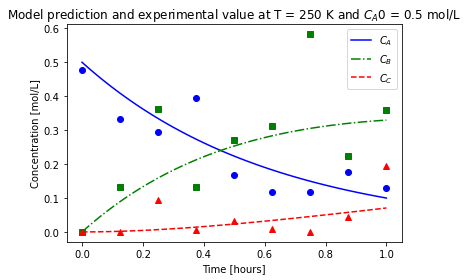

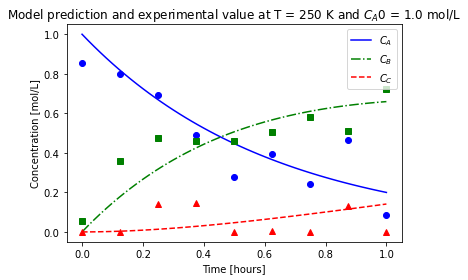

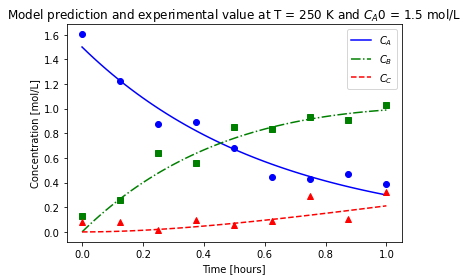

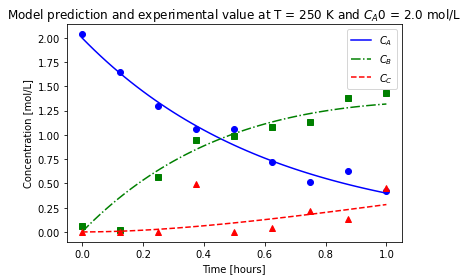

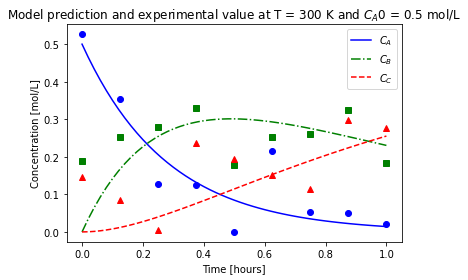

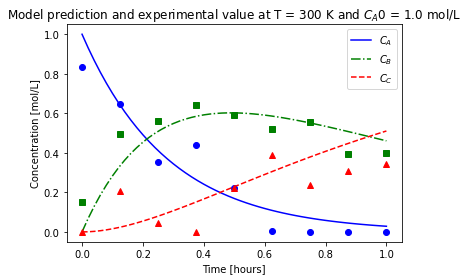

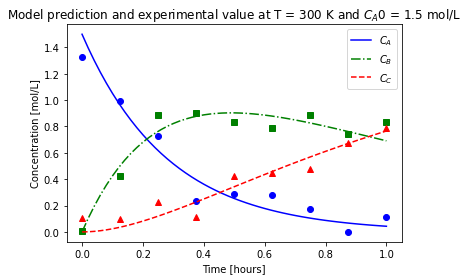

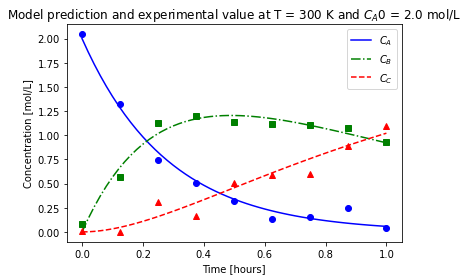

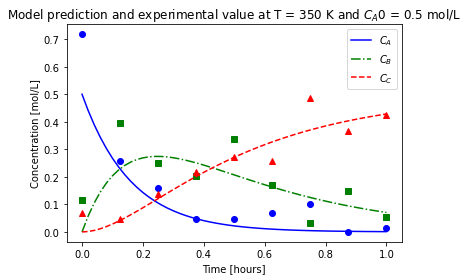

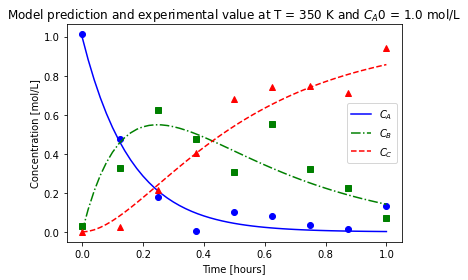

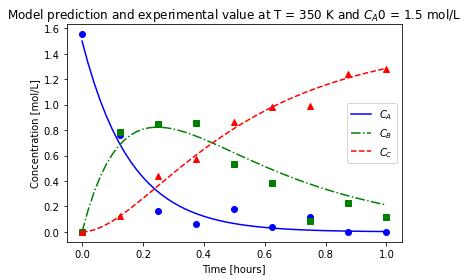

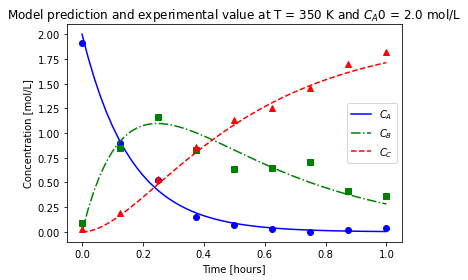

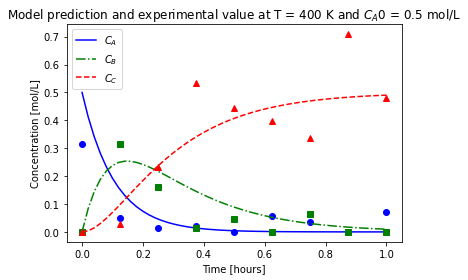

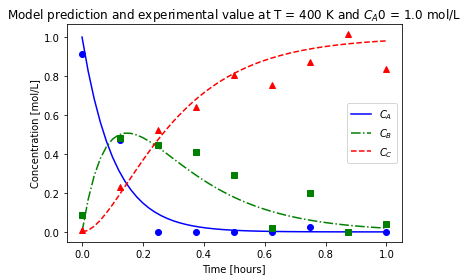

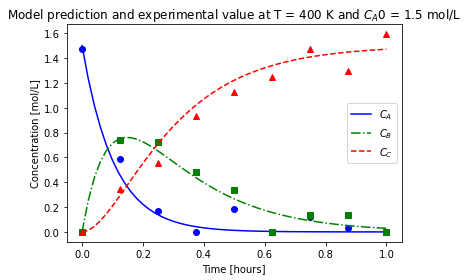

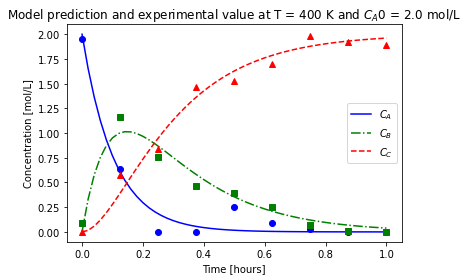

In [10]:
# Parameter values from parameter estimation using parmest
A1 = theta['A1']
E1 = theta['E1']
A2 = theta['A2']
E2 = theta['E2'] 


A_est1 = [A1, A2]
A_est = np.asarray(A_est1)
    
E_est1 = [E1, E2]
E_est = np.asarray(E_est1)

ctr = 0
for T in T_vals:
    for CA0 in CA0_vals:
        # generate concentration profiles using estimated parameter values
        k = kinetics(A_est, E_est, T)
        # plot model-generated and 'experimental' data
        # symbols for 'experimental' data
        # solid and dashed lines for model-generated data
        plot_exp(k, CA0, data_dict_overall[ctr]['data'], 'Model prediction and experimental value at T = {} K and $C_{}$ = {} mol/L'.format(T,'A0',CA0))
        ctr+=1

## 2.8.6 Using `parmest` with `pyomo.dae`

In contrast to the approach above, we will now try to solve the model without the analytic solution for the concentrations using Pyomo.DAE.  To recap, the concentrations in a batch reactor evolve with time per the following differential equations:

$$ \frac{d C_A}{dt} = r_A = -k_1 C_A $$

$$ \frac{d C_B}{dt} = r_B = k_1 C_A - k_2 C_B $$

$$ \frac{d C_C}{dt} = r_C = k_2 C_B $$

This is a linear system of differential equations. Assuming the feed is only species $A$, i.e., 

$$C_A(t=0) = C_{A0} \quad C_B(t=0) = 0 \quad C_C(t=0) = 0$$

In the following cell, we define a function to define and return the Pyomo DAE model (dynamic mode) for the kinetic model to be used for parameter estimation.  In this model, the rate equations are presented in terms of linear differential equations.

In [11]:
def create_model_DAE(data):
    '''
    function to create Pyomo model
    Argument:
        data: a single dictionary of data
    Return:
        m: Pyomo model
    '''
    # data
    exp_data = data['data']
    
    # This code style matches parmest example found here:
    # https://github.com/Pyomo/pyomo/blob/master/pyomo/contrib/parmest/examples/semibatch/semibatch.py
    
    # unpack 'experimental' data into temporary variables
    cameastemp = exp_data['CA']
    cbmeastemp = exp_data['CB']
    ccmeastemp = exp_data['CC']
    tmeastemp = exp_data['time']
    
    # create dictionaries for 'experimental' data of CA, CB,and CC indexed by timestep
    cameas={}
    cbmeas={}
    ccmeas={}
    for i,j in enumerate(tmeastemp):
        cameas[float(j)] = cameastemp[i]
        cbmeas[float(j)] = cbmeastemp[i]
        ccmeas[float(j)] = ccmeastemp[i]
    
    # define Pyomo model
    m = ConcreteModel()
    m.T = data['T'] # K
    m.CA0 = data['CA0'] # mol/L
    
    # define 'experimental' data timesteps as Pyomo ContinuousSet
    m.t = ContinuousSet(bounds = (0.0, tmeastemp.iloc[-1]), initialize=tmeastemp.tolist())
    
    # define 'experimental' data as Pyomo parameters indexed by timestep set and 
    # initialized by dictionary of experimental data
    m.Ca_meas = Param(m.t, initialize=cameas)
    m.Cb_meas = Param(m.t, initialize=cbmeas)
    m.Cc_meas = Param(m.t, initialize=ccmeas)
    
    m.R = 8.31446261815324 # J / K / mole
    
    # Kinetic parameters to be fitted defined as Pyomo variables
    # Initialized by 'true' values
    m.A1 = Var(initialize=200, bounds=(100,300)) # 1/hr
    m.A2 = Var(initialize=400, bounds=(300,500)) # 1/hr
    m.E1 = Var(initialize=10, bounds=(1,20)) # kJ/mol
    m.E2 = Var(initialize=15, bounds=(1,30)) # kJ/mol
    
    # Concentration variables indexed by time
    m.CA = Var(m.t, initialize = m.CA0) # mol/L
    m.CB = Var(m.t, initialize = 0) # mol/L
    m.CC = Var(m.t, initialize = 0) # mol/L
    
    # Derivatives in the model
    #
    m.dCA = DerivativeVar(m.CA)
    m.dCB = DerivativeVar(m.CB)
    m.dCC = DerivativeVar(m.CC)
    
    
    # kinetic rate constants from Arrhenius equation
    m.k1 = Expression(rule = m.A1 * exp(-m.E1*1000/(m.R*m.T))) # 1/hr
    m.k2 = Expression(rule = m.A2 * exp(-m.E2*1000/(m.R*m.T))) # 1/hr
    
    # Constraints to change concentrations based on kinetics
    def conc_A(m,i):
        return m.dCA[i] == - m.k1 * m.CA[i]
    m.CA_rate = Constraint(m.t,rule=conc_A)
    
    def conc_B(m,i):
        return m.dCB[i] == m.k1 * m.CA[i] - m.k2 * m.CB[i]
    m.CB_rate = Constraint(m.t,rule=conc_B)
    
    def conc_C(m,i):
        return m.dCC[i] == m.k2 * m.CB[i]
    m.CC_rate = Constraint(m.t,rule=conc_C)
    
    # Initial Conditions
    def _initcon(m):
        yield m.CA[m.t.first()] == m.CA0
        yield m.CB[m.t.first()] == 0.0
        yield m.CC[m.t.first()] == 0.0
    m.initcon = ConstraintList(rule=_initcon)
    
    # Objective function
    # The objective function for parmest is defined as a 2-stage stochastic optimization objective function
    
    # First stage cost: independent of scenarios ('experiments')
    #                   expression for minimizing fixed realization 
    #                   from model. Eg.: reactor temperature, size, etc.
    def ComputeFirstStageCost_rule(m):
        # In this case, we do not optimize anything besides the kinetic parameters through 
        # least square fitting realizations at each timestep defined by m.t.
        # Hence, the first stage cost is set to 0 here.
        return 0
    m.FirstStageCost = Expression(rule=ComputeFirstStageCost_rule)
    
    # Second stage cost: Realization at each scenario over which the model is defined
    def ComputeSecondStageCost_rule(m):
        # In this problem, we want to minimize the sum of squared errors between 
        # 'experimental' data and the model realization of concentrations of 
        # A, B, and C over each scenario (here, timesteps defined by m.t)
        return sum((m.CA[t] - m.Ca_meas[t]) ** 2 + (m.CB[t] - m.Cb_meas[t]) ** 2 
                       + (m.CC[t] - m.Cc_meas[t]) ** 2 for t in m.t)
    m.SecondStageCost = Expression(rule=ComputeSecondStageCost_rule)
    
    # return the sum of the first-stage and second-stage costs as the objective function
    def total_cost_rule(m):
        return m.FirstStageCost + m.SecondStageCost

    m.Total_Cost_Objective = Objective(rule=total_cost_rule, sense=minimize)
    
    # Discretize model
    disc = TransformationFactory('dae.collocation')
    # The DAE model is discretized using a collocation scheme with 20 finite elements 
    # and 4 collocation points per finite element.
    # Increasing the number of finite elements will improve the solution quality but,
    # it will also increase the solution time.  In our example, oweing to the small problem size,
    # increasing the number of finite elements will not impact the solution time drastically.
    disc.apply_to(m, nfe=20, ncp=4)
    return m

### 2.8.6.1 Parameter estimation with parmest

In the following cell, we perform parameter estimation using parmest to solve the least squares problem defined in the Pyomo dynamic model.

In [12]:
# import parmest
import pyomo.contrib.parmest.parmest as parmest

# defining the names of the parameters in a list
theta_names = ['A1','A2','E1','E2']

# create an object using parmest.Estimator() that stores the Pyomo model realizations for the datasets provided.
# This object which will be used to determined the parameter values that best fit all the datasets
pest = parmest.Estimator(create_model_DAE,data_dict_overall,theta_names,tee=True)

# call the method theta_est() for the Estimator() object defined above to solve 
# the parameter estimation problem.
# theta_est() returns:
    # the overall objective function value
    # estimated parameter values (dictionary with keys = parameters names as defined in the Pyomo model)
obj, theta = pest.theta_est()

print('theta:\n',theta)

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

### 2.8.6.2 Plotting fitted model simulation with 'experimental' data

Next, we plot the 'experimental' data along with the profiles generated using the fitted kinetic model.  The symbols represent the 'experimental' data and the solid and dashed lines are the profiles generated using the fitted model.

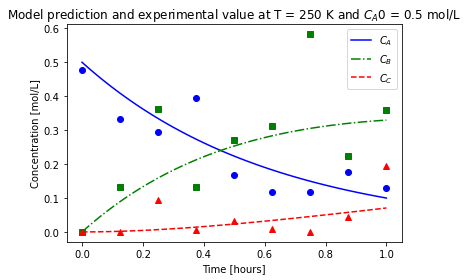

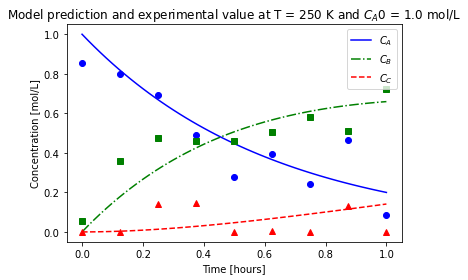

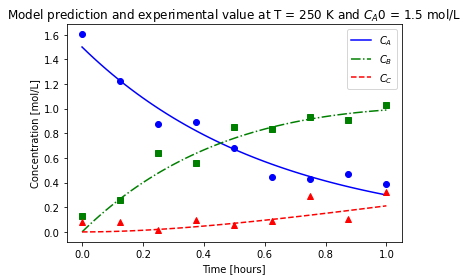

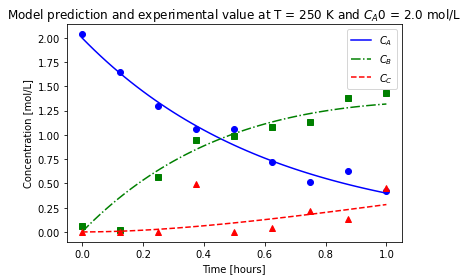

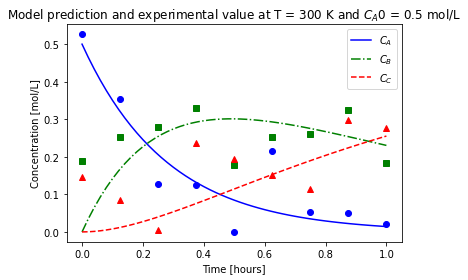

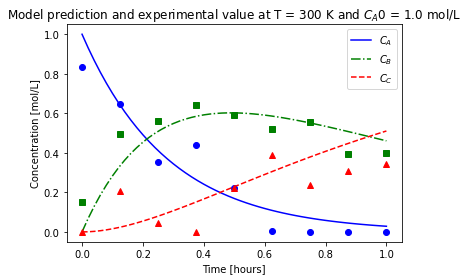

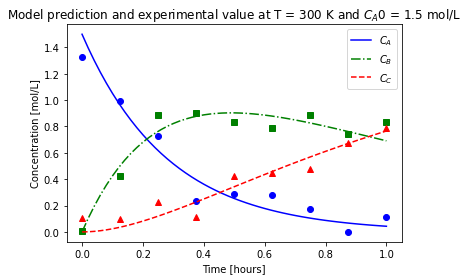

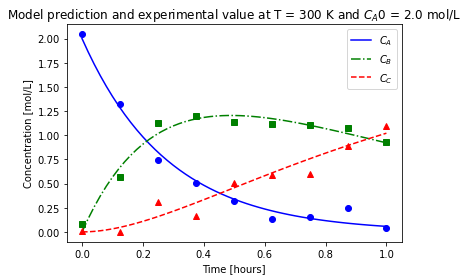

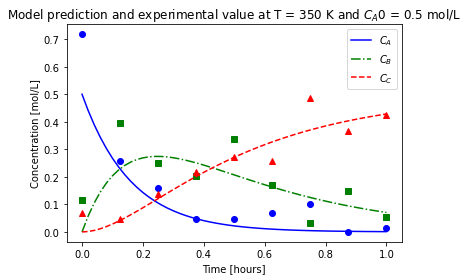

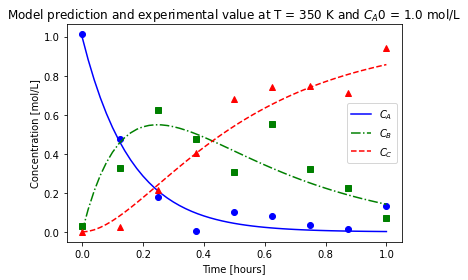

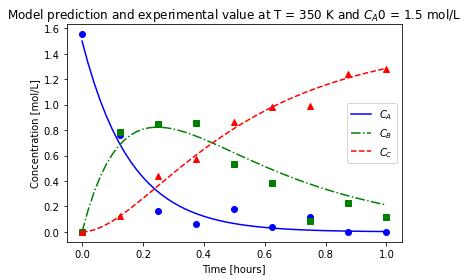

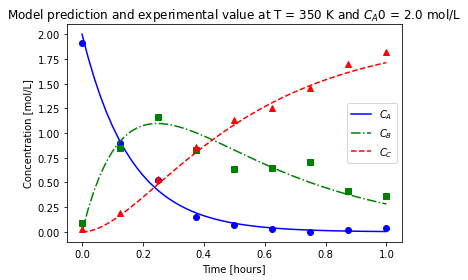

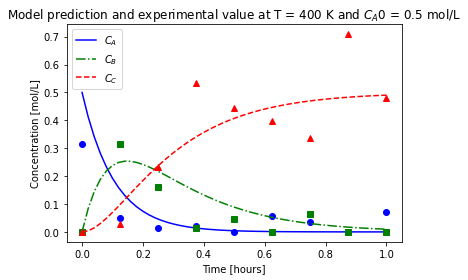

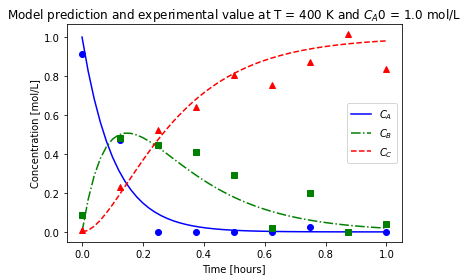

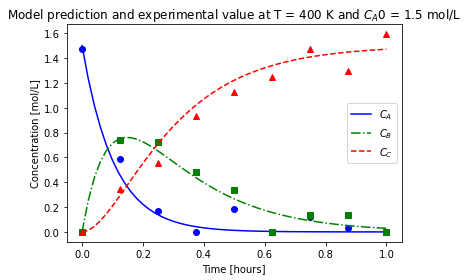

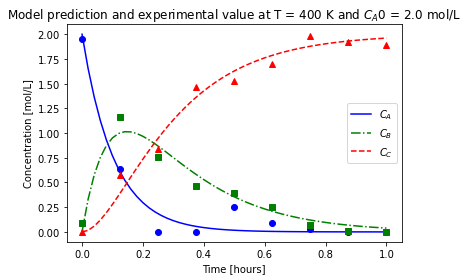

In [13]:
# Parameter values from parameter estimation using parmest
A1 = theta['A1']
E1 = theta['E1']
A2 = theta['A2']
E2 = theta['E2'] 


A_est1 = [A1, A2]
A_est = np.asarray(A_est1)
    
E_est1 = [E1, E2]
E_est = np.asarray(E_est1)

ctr = 0
for T in T_vals:
    for CA0 in CA0_vals:
        # generate concentration profiles using estimated parameter values
        k = kinetics(A_est, E_est, T)
        # plot model-generated and 'experimental' data
        # symbols for 'experimental' data
        # solid and dashed lines for model-generated data
        plot_exp(k, CA0, data_dict_overall[ctr]['data'], 'Model prediction and experimental value at T = {} K and $C_{}$ = {} mol/L'.format(T,'A0',CA0))
        ctr+=1

## 2.8.7 Local uncertainty analysis

### 2.8.7.1 Covariance matrix
The parameter covariance matrix is calculated using the reduced Hessian approach. Using `parmest`, the covariance matrix can be calculated by setting optional argument `calc_cov` to `True`. More information on this approach can be found here: https://doi.org/10.1002/aic.16242

In [14]:
# defining the names of the parameters in a list
theta_names = ['A1','A2','E1','E2']

# create an object using parmest.Estimator() that stores the Pyomo model realizations for the datasets provided.
# This object which will be used to determined the parameter values that best fit all the datasets
pest = parmest.Estimator(create_model_DAE,data_dict_overall,theta_names,tee=True)

# call the method theta_est() for the Estimator() object defined above to solve 
# the parameter estimation problem.
# Argument calc_cov=True is used to return the reduced Hessian matrix for parameter sensitivities
obj, theta, cov = pest.theta_est(calc_cov=True)

print('theta:\n',theta)

Ipopt 3.13.2: bound_relax_factor=0
honor_original_bounds=no


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-sca

### 2.8.7.2 Parameter identifiability

The Fisher information matrix, $FIM$, is calculated as the inverse of the parameter covariance matrix:
$FIM = {(Cov.)}^{-1}$

Eigen decomposition of $FIM$ following $FIM = v \lambda {v}^{-1}$ gives eigenvector matrix $v$ and $\lambda$ is the diagonal matrix of eigenvalues. Column $i$ in $v$ is the eigenvector corresponding to the $i$-th eigenvalue. Further, each element of the eigenvector corresponds to the fitted parameters in order in which they appear in in `theta_names`. The magnitude of each element of an eigenvector denotes the contribution of the parameters on the direciton of the unit vector.

The eigenvector corresponding to the smallest eigenvalue denotes the direction of least variance in the parameter space.  The parameter that corresponds to the major contributor in the eigenvector, then, has the lowest impact on model fit quality. Thus, this parameter is considered sloppy and fixing it's value will not affect overall model behavior.

In [15]:
# Fisher information matrix can be computed using the inverse of the reduced Hessian
fim = np.linalg.inv(cov)

# Eigen decomposition of the Fisher information matrix
eig_values, eig_vectors = np.linalg.eig(fim)

for i,eig in enumerate(eig_values):
    print('***************************************************************')
    print('\nEigen value: {:0.3e}\n'.format(eig))
    print('=== Eigen vector elements with correspondng parameter names ===\n')
    print('------------------------------')
    print('| Vector element | Parameter |')
    print('------------------------------')
    for j,theta_name in enumerate(theta_names):
        if eig_vectors[i,j] < 0.0:
            print('|   {:0.3e}   |    {}     |'.format(eig_vectors[i,j],theta_name))
        else:
            print('|   {:0.3e}    |    {}     |'.format(eig_vectors[i,j],theta_name))
    print('\n')


***************************************************************

Eigen value: 1.559e+01

=== Eigen vector elements with correspondng parameter names ===

------------------------------
| Vector element | Parameter |
------------------------------
|   1.254e-02    |    A1     |
|   -1.789e-03   |    A2     |
|   9.985e-01    |    E1     |
|   -5.373e-02   |    E2     |


***************************************************************

Eigen value: 8.808e+00

=== Eigen vector elements with correspondng parameter names ===

------------------------------
| Vector element | Parameter |
------------------------------
|   1.519e-03    |    A1     |
|   6.805e-03    |    A2     |
|   5.373e-02    |    E1     |
|   9.985e-01    |    E2     |


***************************************************************

Eigen value: 5.745e-05

=== Eigen vector elements with correspondng parameter names ===

------------------------------
| Vector element | Parameter |
------------------------------
|   -9.

Looking at the eigenvalues and corresponding eigenvectors, we can see that parameters A2 and A1 (in order) have the largest contributions to the direction of the eigenvector corresponding to the smallest eigenvalue.  Therefore, as discussed above, we can conclude from this analysis that parameter A2 is the least identifiable parameter in this kinetic model, followed by parameter A1.

## 2.8.8 Bootstrap resampling
Bootstrapping is a resampling method by independently sampling with replacement from an existing sample data with same sample size n, and performing inference among these resampled data ([link](https://towardsdatascience.com/an-introduction-to-the-bootstrap-method-58bcb51b4d60)). Bootstrap resampling is often used in parameter estimation problems to determine parameter confidence intervals. More information about bootstrap resampling and confidence interval calculation can be found [here](https://ocw.mit.edu/courses/mathematics/18-05-introduction-to-probability-and-statistics-spring-2014/readings/MIT18_05S14_Reading24.pdf).

`theta_est_bootstrap()` is used to perform resampling with `parmest`.  More information can be found [here](https://pyomo.readthedocs.io/en/stable/contributed_packages/parmest/api.html#pyomo.contrib.parmest.parmest.Estimator.theta_est_bootstrap).

`parmest` also provides functions to plot bootstrap parameter estimates along with various confidence intervals [link](https://pyomo.readthedocs.io/en/stable/contributed_packages/parmest/api.html#pyomo.contrib.parmest.graphics.pairwise_plot).

In [16]:
# create Estimator object
pest = parmest.Estimator(create_model_DAE,data_dict_overall,theta_names,tee=True)

### Parameter estimation with bootstrap resampling
#
bootstrap_theta = pest.theta_est_bootstrap(10)
print(bootstrap_theta.head())

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

Once the parameter estimates are generated through bootstrap resampling, we can visualize the estimates using the `pairwise_plot()` function as follows:

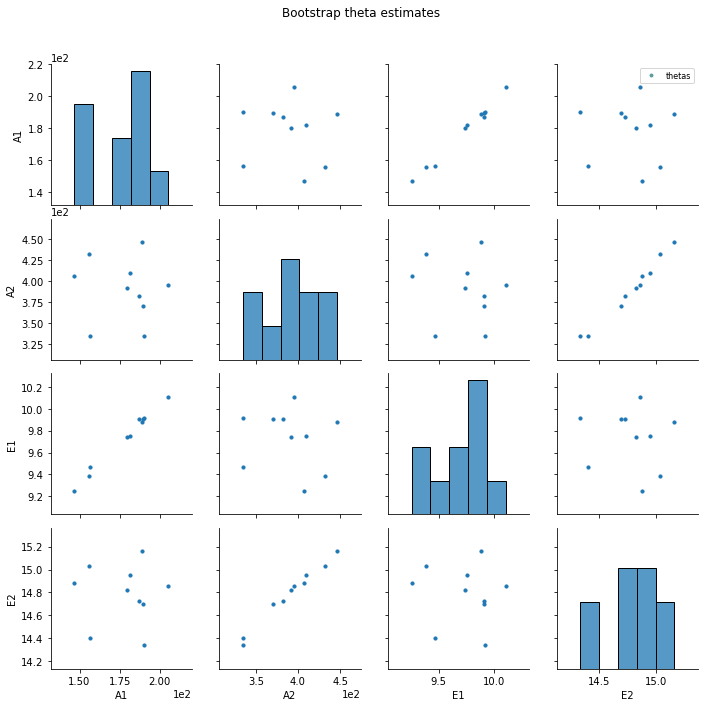

In [17]:
# plot parameter estimate
pyomo.contrib.parmest.graphics.pairwise_plot(bootstrap_theta, title='Bootstrap theta estimates')


Confidence regions can be plotted around the bootstrap estimates for various distributions with confidence $\alpha$.

{'A1': 185.60880919391855, 'A2': 401.1701986690201, 'E1': 9.866878980549789, 'E2': 14.866030768895133}


/Users/kghosh/anaconda3/envs/idaes-pse-dev-pyomo6-1/lib/python3.8/site-packages/pyomo/contrib/parmest/graphics.py:151: UserWarning: No contour levels were found within the data range.
  ax.contour(X,Y,Z, levels=[alpha], colors=color)


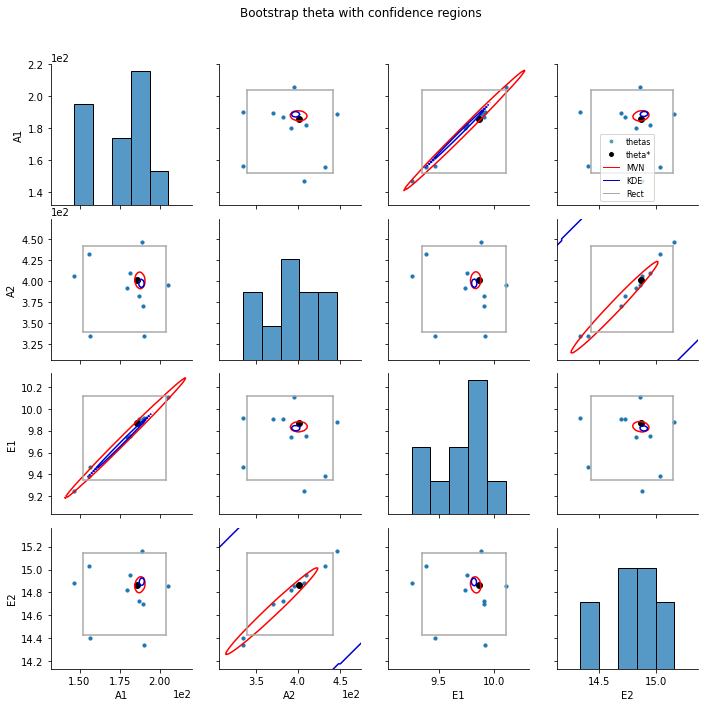

In [18]:
# plot bootstrap parameter estimates with confidence intervals
pyomo.contrib.parmest.graphics.pairwise_plot(bootstrap_theta, theta, 0.8, ['MVN', 'KDE', 'Rect'], 
                      title='Bootstrap theta with confidence regions')

## 2.8.9 Nonlinear confidence regions

The likelihood-ratio test (sometimes called the likelihood-ratio $\chi^2$ test) is a hypothesis test that helps one choose the “best” model between two models[link](https://www.statisticshowto.com/likelihood-ratio-tests/). Basically, the test compares the fit of two models. The null hypothesis is that the first model is the “best” model; It is rejected when the test statistic is large. In other words, if the null hypothesis is rejected, then the second model is a significant improvement over the first model.

In the last part of this notebook, we use the bootstrap parameter estimates to determine the goodness of fit using the likelihood-ratio $\chi^2$ test. More information can be found [here](https://pyomo.readthedocs.io/en/stable/contributed_packages/parmest/api.html#pyomo.contrib.parmest.parmest.Estimator.likelihood_ratio_test).

In [19]:
from itertools import product
### Likelihood ratio test

# generate arrays of parameter values
A1 = np.arange(180.0, 190.0, 1.0)
A2 = np.arange(395.0, 405.0, 1.0)
E1 = np.arange(5.0, 15.0, 1.0)
E2 = np.arange(10.0, 20.0, 1.0)

# format parameter values into a pandas dataframe to be provided as input to calculate 
# corresponding objective function values
# theta_vals = pd.DataFrame(list(product(A1, A2, E1, E2)), columns=theta_names)
theta_vals = bootstrap_theta
obj_at_theta = pest.objective_at_theta(theta_vals)
print(obj_at_theta.head())

           A1          A2        E1         E2       obj
0  186.769746  382.642388  9.907827  14.726285  0.222375
1  179.703097  392.070899  9.738017  14.824106  0.222957
2  156.529846  334.342272  9.464807  14.407121  0.224970
3  146.617094  406.533938  9.252072  14.878677  0.225126
4  189.635337  370.602660  9.907778  14.697935  0.222650


In [20]:
LR = pest.likelihood_ratio_test(obj_at_theta, obj, [0.8, 0.85, 0.9, 0.95])
print(LR.head())

           A1          A2        E1         E2       obj   0.8  0.85   0.9  \
0  186.769746  382.642388  9.907827  14.726285  0.222375  True  True  True   
1  179.703097  392.070899  9.738017  14.824106  0.222957  True  True  True   
2  156.529846  334.342272  9.464807  14.407121  0.224970  True  True  True   
3  146.617094  406.533938  9.252072  14.878677  0.225126  True  True  True   
4  189.635337  370.602660  9.907778  14.697935  0.222650  True  True  True   

   0.95  
0  True  
1  True  
2  True  
3  True  
4  True  


The likelihood ratio test results with confidence $\alpha$ can be visualized as follows:

Objective contour plot for A1 A2 slice failed
Objective contour plot for A1 E1 slice failed
Objective contour plot for A2 E1 slice failed
Objective contour plot for A1 E2 slice failed
Objective contour plot for A2 E2 slice failed
Objective contour plot for E1 E2 slice failed
Objective contour plot for A2 A1 slice failed
Objective contour plot for E1 A1 slice failed
Objective contour plot for E2 A1 slice failed
Objective contour plot for E1 A2 slice failed
Objective contour plot for E2 A2 slice failed
Objective contour plot for E2 E1 slice failed


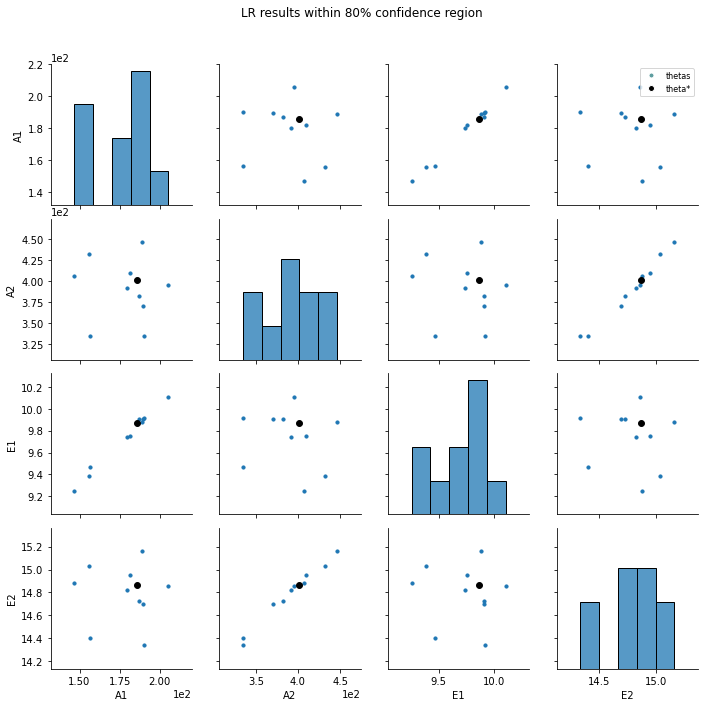

In [21]:
pyomo.contrib.parmest.graphics.pairwise_plot(LR, theta, 0.8, 
                      title='LR results within 80% confidence region')

<!--NAVIGATION-->
< [2.7 Stochastic Programming](https://ndcbe.github.io/CBE60499/02.07-SP.html) | [Contents](toc.html) | [Tag Index](tag_index.html) | [2.9 Supplementary material: data for parmest tutorial](https://ndcbe.github.io/CBE60499/02.09-Parmest-generate-data.html) ><p><a href="https://colab.research.google.com/github/ndcbe/CBE60499/blob/master/docs/02.08-Parmest-tutorial.ipynb"> <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://ndcbe.github.io/CBE60499/02.08-Parmest-tutorial.ipynb"> <img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>